# Step 1: Text Cleaning & Preprocessing
This notebook begins the feature engineering process for multi-label text classification.

**Goals:**
- Remove noise from review text (lowercase, remove HTML, URLs, special characters, extra whitespace)
- Handle missing values in text fields
- (Optional) Remove stopwords, lemmatize/stem (not always needed for transformers)


In [21]:
# Import libraries
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

Data Loading

In [22]:
# Try reading the dataset with different encodings
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

for encoding in encodings:
    try:
        print(f"Trying encoding: {encoding}")
        df = pd.read_csv('../data/external/mendeley_sri_lanka_reviews.csv', encoding=encoding)
        print(f"Successfully read the file with {encoding} encoding")
        break
    except UnicodeDecodeError:
        print(f"Failed with {encoding} encoding")
        continue

Trying encoding: utf-8
Failed with utf-8 encoding
Trying encoding: latin1
Successfully read the file with latin1 encoding


In [23]:
# Define text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ''
    # Lowercase (if using uncased model)
    text = text.lower()
    # Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [24]:
# Apply cleaning to review text and title
df['clean_text'] = df['Text'].apply(clean_text)
df['clean_title'] = df['Title'].apply(clean_text)

df[['Text', 'clean_text', 'Title', 'clean_title']].head()

,Text,clean_text,Title,clean_title
0,I had a manicure here and it really was profes...,i had a manicure here and it really was profes...,Best nail spa in Arugam bay on the water!,best nail spa in arugam bay on the water!
1,"Overall, it is a wonderful experience. We visi...","overall, it is a wonderful experience. we visi...",Best for surfing,best for surfing
2,"Great place to chill, swim, surf, eat, shop, h...","great place to chill, swim, surf, eat, shop, h...",We Love Arugam Bay,we love arugam bay
3,Good place for surf and a few stores to going ...,good place for surf and a few stores to going ...,Sun and waves.,sun and waves.
4,This place is great for surfing but even if yo...,this place is great for surfing but even if yo...,"Great swimming, surfing, great fish aznd frien...","great swimming, surfing, great fish aznd frien..."


In [25]:
# Handle missing values: drop rows with empty clean_text
df = df[df['clean_text'].str.strip() != '']
df = df.reset_index(drop=True)
print(f'Rows after dropping missing/empty text: {len(df)}')

Rows after dropping missing/empty text: 16156


# Step 2: Label Preparation

We will convert experiential dimensions (e.g., Regenerative, Wellness, Culinary, Adventure) into multi-hot encoded vectors for each review. Each review will have a binary vector indicating the presence or absence of each experiential label.

In [26]:
# Define keywords for each experiential dimension
experiential_keywords = {
    'Regenerative & Eco-Tourism': [
        'eco', 'sustainable', 'environmental', 'community', 'local', 'organic',
        'conservation', 'green', 'renewable', 'village', 'traditional', 'culture'
    ],
    'Integrated Wellness': [
        'wellness', 'spa', 'yoga', 'meditation', 'ayurveda', 'relax', 'peaceful',
        'tranquil', 'healing', 'therapy', 'massage', 'retreat', 'mindfulness'
    ],
    'Immersive Culinary': [
        'food', 'cuisine', 'restaurant', 'cooking', 'chef', 'taste', 'delicious',
        'authentic', 'local food', 'spices', 'curry', 'rice', 'seafood', 'market'
    ],
    'Off-the-Beaten-Path Adventure': [
        'adventure', 'hiking', 'trekking', 'wildlife', 'safari', 'nature', 'explore',
        'remote', 'off the beaten path', 'jungle', 'forest', 'mountain', 'river'
    ]
}

# Function to count keyword occurrences
def count_keywords(text, keywords):
    if pd.isna(text):
        return 0
    text_lower = text.lower()
    count = 0
    for keyword in keywords:
        count += text_lower.count(keyword.lower())
    return count

# Count keywords for each dimension
for dimension, keywords in experiential_keywords.items():
    df[f'{dimension}_keyword_count'] = df['Text'].apply(lambda x: count_keywords(x, keywords))

In [27]:
df.head()

,Location_Name,Located_City,Location,Location_Type,User_ID,User_Location,User_Locale,User_Contributions,Travel_Date,Published_Date,Rating,Helpful_Votes,Title,Text,clean_text,clean_title,Regenerative & Eco-Tourism_keyword_count,Integrated Wellness_keyword_count,Immersive Culinary_keyword_count,Off-the-Beaten-Path Adventure_keyword_count
0,Arugam Bay,Arugam Bay,"Arugam Bay, Eastern Province",Beaches,User 1,"Dunsborough, Australia",en_US,8,2019-07,2019-07-31T07:53:21-04:00,5,1,Best nail spa in Arugam bay on the water!,I had a manicure here and it really was profes...,i had a manicure here and it really was profes...,best nail spa in arugam bay on the water!,1,2,0,0
1,Arugam Bay,Arugam Bay,"Arugam Bay, Eastern Province",Beaches,User 2,"Bendigo, Australia",en_US,4,2019-06,2019-07-21T21:50:11-04:00,4,0,Best for surfing,"Overall, it is a wonderful experience. We visi...","overall, it is a wonderful experience. we visi...",best for surfing,0,0,1,0
2,Arugam Bay,Arugam Bay,"Arugam Bay, Eastern Province",Beaches,User 3,"Melbourne, Australia",en_US,13,2019-07,2019-07-15T18:52:55-04:00,5,0,We Love Arugam Bay,"Great place to chill, swim, surf, eat, shop, h...","great place to chill, swim, surf, eat, shop, h...",we love arugam bay,1,0,0,0
3,Arugam Bay,Arugam Bay,"Arugam Bay, Eastern Province",Beaches,User 4,"Ericeira, Portugal",en_US,4,2019-06,2019-07-03T10:32:41-04:00,5,0,Sun and waves.,Good place for surf and a few stores to going ...,good place for surf and a few stores to going ...,sun and waves.,0,0,0,0
4,Arugam Bay,Arugam Bay,"Arugam Bay, Eastern Province",Beaches,User 5,"Pistoia, Italy",en_US,14,2019-07,2019-07-02T17:07:02-04:00,5,0,"Great swimming, surfing, great fish aznd frien...",This place is great for surfing but even if yo...,this place is great for surfing but even if yo...,"great swimming, surfing, great fish aznd frien...",1,0,1,0


In [28]:
# Create multi-hot encoded label columns for each experiential dimension
label_map = {
    'Regenerative & Eco-Tourism': 'label_regenerative_eco_tourism',
    'Integrated Wellness': 'label_integrated_wellness',
    'Immersive Culinary': 'label_immersive_culinary',
    'Off-the-Beaten-Path Adventure': 'label_off_the_beaten_path_adventure'
}

for dim, label_col in label_map.items():
    count_col = f'{dim}_keyword_count'
    df[label_col] = (df[count_col] > 0).astype(int)

# Check label distribution
print('Label distribution:')
for label_col in label_map.values():
    print(f"{label_col}: {df[label_col].sum()} positive samples")

# Preview label columns
label_cols = list(label_map.values())
df[label_cols].head()

Label distribution:
label_regenerative_eco_tourism: 4012 positive samples
label_integrated_wellness: 1497 positive samples
label_immersive_culinary: 2525 positive samples
label_off_the_beaten_path_adventure: 3118 positive samples


,label_regenerative_eco_tourism,label_integrated_wellness,label_immersive_culinary,label_off_the_beaten_path_adventure
0,1,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,0
4,1,0,1,0


# Step 3: Feature Engineering

Now that labels are prepared, we will focus on feature engineering for multi-label text classification.

**Plan:**
- **Text features:** The main input will be the cleaned review text (`clean_text`). Optionally, the cleaned title (`clean_title`) can be included.
- **Auxiliary features (optional):** User experience level, location type, rating, temporal features (season, month), and keyword counts are available for future experiments.
- **Decision:** For transformer models, we will start with text only. Auxiliary features can be added later if needed.

Let's preview the available features.

In [29]:
# Preview text and auxiliary features
text_cols = ['clean_text', 'clean_title']
auxiliary_cols = []
# Check for common auxiliary columns
possible_aux = ['User Experience Level', 'Location Type', 'Rating', 'Date', 'Month', 'Season']
for col in possible_aux:
    if col in df.columns:
        auxiliary_cols.append(col)
# Add keyword count columns as auxiliary features
keyword_count_cols = [col for col in df.columns if col.endswith('_keyword_count')]
auxiliary_cols += keyword_count_cols

print('Text columns:')
print(text_cols)
print('\nAuxiliary feature columns available:')
print(auxiliary_cols)

# Preview a few rows
display_cols = text_cols + auxiliary_cols
print('\nSample of text and auxiliary features:')
display(df[display_cols].head())

# For transformer models, we will use only clean_text as input for now

Text columns:
['clean_text', 'clean_title']

Auxiliary feature columns available:
['Rating', 'Regenerative & Eco-Tourism_keyword_count', 'Integrated Wellness_keyword_count', 'Immersive Culinary_keyword_count', 'Off-the-Beaten-Path Adventure_keyword_count']

Sample of text and auxiliary features:


,clean_text,clean_title,Rating,Regenerative & Eco-Tourism_keyword_count,Integrated Wellness_keyword_count,Immersive Culinary_keyword_count,Off-the-Beaten-Path Adventure_keyword_count
0,i had a manicure here and it really was profes...,best nail spa in arugam bay on the water!,5,1,2,0,0
1,"overall, it is a wonderful experience. we visi...",best for surfing,4,0,0,1,0
2,"great place to chill, swim, surf, eat, shop, h...",we love arugam bay,5,1,0,0,0
3,good place for surf and a few stores to going ...,sun and waves.,5,0,0,0,0
4,this place is great for surfing but even if yo...,"great swimming, surfing, great fish aznd frien...",5,1,0,1,0


## Exploring Auxiliary Features and Label Columns

In addition to text features, we can explore auxiliary features such as user experience, location type, rating, temporal features, keyword counts, and the multi-hot label columns themselves. This helps us understand feature distributions and potential correlations with the target labels.

Let's examine the distributions and relationships among these features.

In [30]:
# List all label columns and auxiliary features
label_cols = [col for col in df.columns if col.startswith('label_')]
keyword_count_cols = [col for col in df.columns if col.endswith('_keyword_count')]
possible_aux = ['User Experience Level', 'Location Type', 'Rating', 'Date', 'Month', 'Season']
auxiliary_cols = [col for col in possible_aux if col in df.columns] + keyword_count_cols + label_cols

print('Auxiliary feature columns (including labels):')
print(auxiliary_cols)

# Show distributions for label columns
print('\nLabel column distributions:')
for col in label_cols:
    print(f"{col}: {df[col].sum()} positive samples")

# Preview a few rows of auxiliary features and labels
display_cols = auxiliary_cols
print('\nSample of auxiliary features and label columns:')
display(df[display_cols].head())

# Optional: Correlation matrix between auxiliary features and labels
corr_cols = keyword_count_cols + label_cols
if corr_cols:
    print('\nCorrelation matrix (keyword counts and labels):')
    display(df[corr_cols].corr())

Auxiliary feature columns (including labels):
['Rating', 'Regenerative & Eco-Tourism_keyword_count', 'Integrated Wellness_keyword_count', 'Immersive Culinary_keyword_count', 'Off-the-Beaten-Path Adventure_keyword_count', 'label_regenerative_eco_tourism', 'label_integrated_wellness', 'label_immersive_culinary', 'label_off_the_beaten_path_adventure']

Label column distributions:
label_regenerative_eco_tourism: 4012 positive samples
label_integrated_wellness: 1497 positive samples
label_immersive_culinary: 2525 positive samples
label_off_the_beaten_path_adventure: 3118 positive samples

Sample of auxiliary features and label columns:


,Rating,Regenerative & Eco-Tourism_keyword_count,Integrated Wellness_keyword_count,Immersive Culinary_keyword_count,Off-the-Beaten-Path Adventure_keyword_count,label_regenerative_eco_tourism,label_integrated_wellness,label_immersive_culinary,label_off_the_beaten_path_adventure
0,5,1,2,0,0,1,1,0,0
1,4,0,0,1,0,0,0,1,0
2,5,1,0,0,0,1,0,0,0
3,5,0,0,0,0,0,0,0,0
4,5,1,0,1,0,1,0,1,0



Correlation matrix (keyword counts and labels):


,Regenerative & Eco-Tourism_keyword_count,Integrated Wellness_keyword_count,Immersive Culinary_keyword_count,Off-the-Beaten-Path Adventure_keyword_count,label_regenerative_eco_tourism,label_integrated_wellness,label_immersive_culinary,label_off_the_beaten_path_adventure
Regenerative & Eco-Tourism_keyword_count,1.000000,0.069038,0.128387,0.159188,0.865421,0.052982,0.092979,0.122045
Integrated Wellness_keyword_count,0.069038,1.000000,0.057644,0.050891,0.056351,0.928296,0.031970,0.041528
Immersive Culinary_keyword_count,0.128387,0.057644,1.000000,0.048890,0.089958,0.044258,0.822979,0.028727
Off-the-Beaten-Path Adventure_keyword_count,0.159188,0.050891,0.048890,1.000000,0.116495,0.047103,0.028600,0.771266
label_regenerative_eco_tourism,0.865421,0.056351,0.089958,0.116495,1.000000,0.045087,0.074948,0.098999
label_integrated_wellness,0.052982,0.928296,0.044258,0.047103,0.045087,1.000000,0.025299,0.038994
label_immersive_culinary,0.092979,0.031970,0.822979,0.028600,0.074948,0.025299,1.000000,0.012392
label_off_the_beaten_path_adventure,0.122045,0.041528,0.028727,0.771266,0.098999,0.038994,0.012392,1.000000


## Visualizing Relationships Between Auxiliary Features and Labels

To better understand the relationships between auxiliary features (including keyword counts) and the multi-hot label columns, let's visualize their correlations using a heatmap. We'll also plot the distribution of each label.

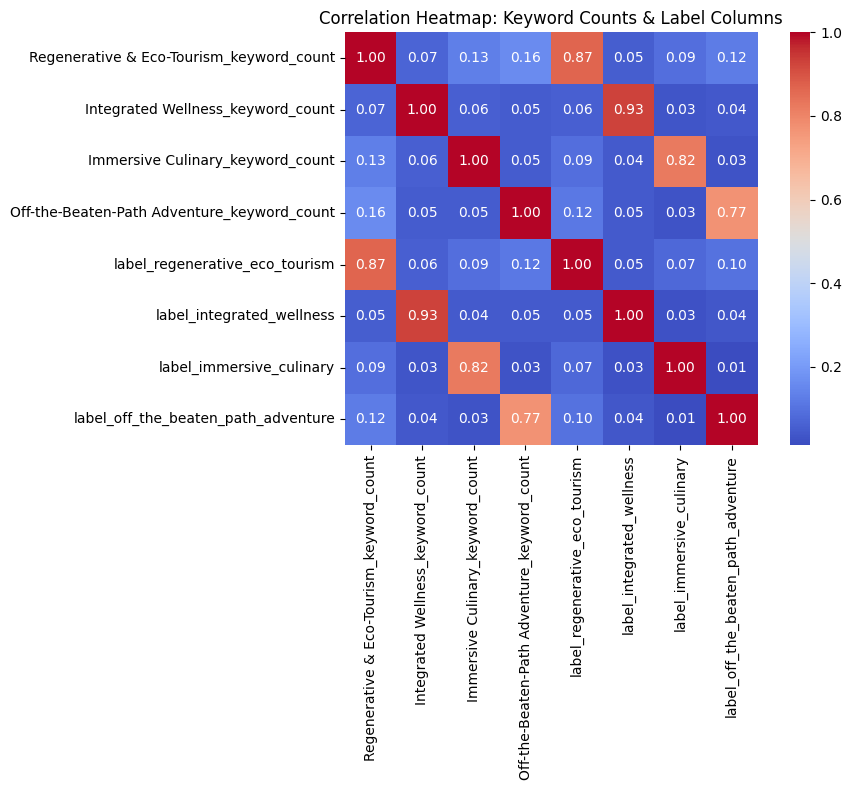

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_60855/21606728.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_sums.index, y=label_sums.values, palette='viridis')


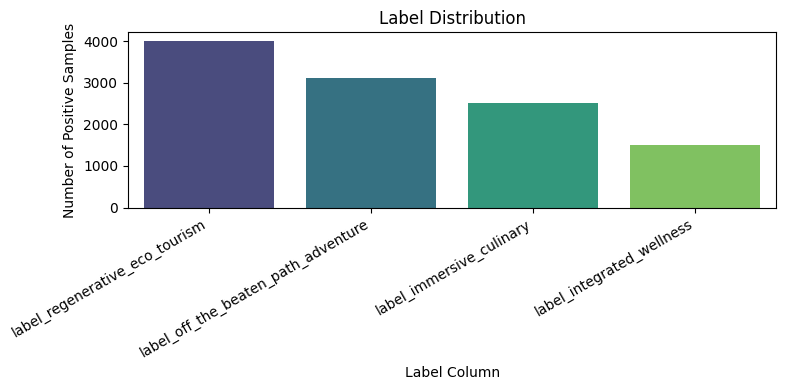

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap between keyword counts and label columns
corr_cols = [col for col in df.columns if col.endswith('_keyword_count') or col.startswith('label_')]
corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap: Keyword Counts & Label Columns')
plt.tight_layout()
plt.show()

# Bar plot for label distributions
label_cols = [col for col in df.columns if col.startswith('label_')]
label_sums = df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=label_sums.index, y=label_sums.values, palette='viridis')
plt.ylabel('Number of Positive Samples')
plt.xlabel('Label Column')
plt.title('Label Distribution')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

## Finalizing Feature Engineering and Saving Processed Data

We have completed feature engineering. Let's save the processed DataFrame for use in the modeling notebook.

In [32]:
# Save processed DataFrame for modeling
import os

output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Save as CSV
df.to_csv(os.path.join(output_dir, 'tourism_reviews_processed.csv'), index=False)
# Save as pickle (preserves dtypes, recommended for pandas)
df.to_pickle(os.path.join(output_dir, 'tourism_reviews_processed.pkl'))

print('Processed data saved to:', output_dir)

Processed data saved to: ../data/processed
